# "the" consistency

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [2]:
import bz2
import os
import ujson
import attr
import re

import pandas as pd
import numpy as np
import statsmodels.api as sm

from glob import glob
from collections import Counter, UserDict
from itertools import islice
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression

/Users/enderlej/.virtualenvs/th/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
@attr.s
class Dataset:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
    
    def novels(self):
        for path in tqdm_notebook(self.paths()):
            with bz2.open(path) as fh:
                for line in fh:
                    yield ujson.loads(line)

In [4]:
ds = Dataset('data/a-the-and-or.json/')

In [119]:
counts = [
    np.diff(np.array(novel['counts']['the']))
    for novel in ds.novels()
    if sum(novel['counts']['the'])
]

counts = [c[:-1].reshape(-1, 3).sum(axis=1) for c in counts]
# counts = [(c[:-2] + c[1:-1] + c[2:]) / 3 for c in counts]
# counts = [(c[:-4] + c[1:-3] + c[2:-2] + c[3:-1] + c[4:]) / 5 for c in counts]

md_keys = ['author_first', 'author_last', 'corpus', 'identifier', 'pub_year', 'title']
metadata_table = [[novel.get(k) for k in md_keys]
                  for novel in ds.novels()
                  if sum(novel['counts']['the'])]
metadata = pd.DataFrame(metadata_table, columns=md_keys)

In [120]:
def lin_reg(counts):
    x = np.arange(len(counts))
    x = sm.add_constant(x)
    reg = sm.OLS(counts, x)
    return reg, reg.fit()

In [121]:
def plot_lin_reg(reg, fit):
    
    pred = fit.predict()
    x1 = reg.exog[0][1]
    x2 = reg.exog[-1][1]
    y1 = pred[0]
    y2 = pred[-1]
    
    plt.figure(figsize=(4,2))
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    plt.plot(reg.endog)
    plt.show()

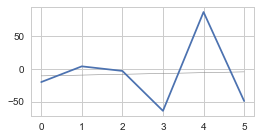

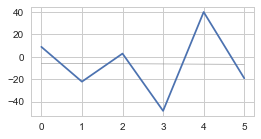

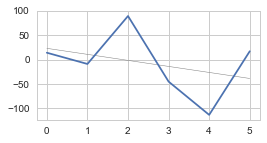

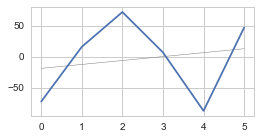

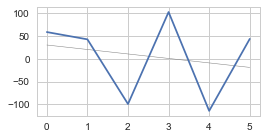

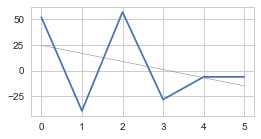

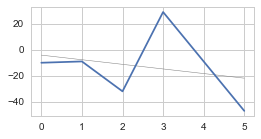

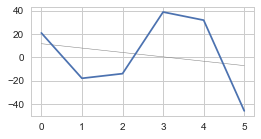

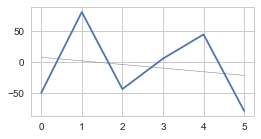

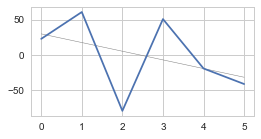

In [122]:
for c in counts[:10]:
    plot_lin_reg(*lin_reg(c))

In [123]:
fits_list = []
for c in tqdm_notebook(counts):
    reg, fit = lin_reg(c)
    fits_list.append((fit.params[1], fit.pvalues[1]))

/Users/enderlej/.virtualenvs/th/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/enderlej/.virtualenvs/th/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/enderlej/.virtualenvs/th/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/enderlej/.virtualenvs/th/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [124]:
fits_coef, fits_p = zip(*fits_list)
metadata = metadata.assign(coef=fits_coef, p=fits_p)
metadata.to_csv('metadata/novels-metadata-thediff-coefs.csv')
fits = metadata[['coef', 'p']]

# Falling "the" (diff)

In [125]:
len(fits[(fits['coef'] < 0) & (fits['p'] < 0.05)]) / len(fits)

0.0027228317450148152

In [126]:
len(fits[(fits['coef'] < 0) & (fits['p'] < 0.01)]) / len(fits)

0.0005605830063265797

# Rising "the" (diff)

In [130]:
len(fits[(fits['coef'] > 0) & (fits['p'] < 0.05)]) / len(fits)

0.015576199247217105

In [128]:
len(fits[(fits['coef'] > 0) & (fits['p'] < 0.01)]) / len(fits)

0.0025226235284696082